# Wokflow  **TEST** con Full Bayesiana 

## Inicializacion

In [1]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-11-16 13:56:06 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657967,35.2,1454668,77.7,1230794,65.8
Vcells,1221279,9.4,8388608,64.0,1975151,15.1


In [2]:
plocal <- list()

plocal$qcanaritos <- 5L
plocal$min_data_in_leaf <- 2000L
plocal$learning_rate <- 1.0
plocal$gradient_bound <- 0.01


plocal$APO <- 1
plocal$ksemillerio <- 1


In [3]:
PARAM <- list()
PARAM$experimento <- "c_apo_10"
PARAM$semilla_primigenia <- 444449

In [4]:
setwd("/content/buckets/b1/exp")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

## Preprocesamiento

### Generacion de la clase_ternaria

In [5]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset <- fread("~/datasets/competencia_02_crudo.csv.gz" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-11-16 13:56:06 UTC"

Loading required package: data.table



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,766840,41.0,1454668,77.7,1454668,77.7
Vcells,722144102,5509.6,1017394191,7762.2,845997388,6454.5


[1] "2025-11-16 13:56:33 UTC"

In [6]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
201901,BAJA+1,645
201901,BAJA+2,729
201901,CONTINUA,122899
201902,BAJA+1,733
201902,BAJA+2,707
201902,CONTINUA,123961
201903,BAJA+1,708
201903,BAJA+2,751
201903,CONTINUA,124508


### Eliminacion de Features

Completar a gusto LUEGO de realizar un analisis exploratorio de datos.
<br> No necesariamente en esta Segunda Competencia conviele eliminar los mismos campos que en la Primera ...

In [7]:
# Salsa Magica para 202106
dataset[, mprestamos_personales := NULL ]
dataset[, cprestamos_personales := NULL ]

### Data Quality

In [8]:
# 1. Identificar las columnas numéricas a chequear
#    (Excluimos IDs y la propia foto_mes)
numeric_types <- c("integer", "numeric", "double", "integer64")
all_cols <- names(dataset)

# Obtenemos los nombres de las columnas que son numéricas
cols_a_chequear <- all_cols[sapply(dataset, function(x) class(x)[1] %in% numeric_types)]

# Quitamos las que no son features (ID, fecha)
cols_a_chequear <- setdiff(cols_a_chequear, c("numero_de_cliente", "foto_mes"))

# 2. Calcular el porcentaje de ceros por mes
#    (sum(x == 0, na.rm = TRUE) / .N)
#    Esto es idéntico a la lógica de Polars: 
#    - sum(x==0, na.rm=T) equivale a (pl.col(c)==0).sum()
#    - .N equivale a pl.len()
resumen_wide <- dataset[, 
                        lapply(.SD, function(x) sum(x == 0, na.rm = TRUE) / .N), 
                        by = foto_mes, 
                        .SDcols = cols_a_chequear]

# 3. Convertir (melt) la tabla a formato largo
resumen_long <- melt(resumen_wide, 
                     id.vars = "foto_mes", 
                     variable.name = "variable", 
                     value.name = "porcentaje_ceros")

# 4. Filtrar y crear la lista de problemas
#    Nos quedamos solo con los que son 100% ceros (porcentaje == 1)
lista_problemas <- resumen_long[porcentaje_ceros == 1, 
                                .(foto_mes, variable)]

setorder(lista_problemas, foto_mes, variable)

# 5. Mostrar el resultado
print("Columnas que son 100% CERO en un mes:")
print(lista_problemas)

[1] "Columnas que son 100% CERO en un mes:"
    foto_mes                           variable
       <int>                             <fctr>
 1:   201904  ctarjeta_visa_debitos_automaticos
 2:   201904 mttarjeta_visa_debitos_automaticos
 3:   201905                      mrentabilidad
 4:   201905               mrentabilidad_annual
 5:   201905                        mcomisiones
 6:   201905                    mactivos_margen
 7:   201905                    mpasivos_margen
 8:   201905                  ccomisiones_otras
 9:   201905                  mcomisiones_otras
10:   201910                      mrentabilidad
11:   201910               mrentabilidad_annual
12:   201910                        mcomisiones
13:   201910                    mactivos_margen
14:   201910                    mpasivos_margen
15:   201910        ccajeros_propios_descuentos
16:   201910        mcajeros_propios_descuentos
17:   201910           ctarjeta_visa_descuentos
18:   201910           mtarjeta_visa_descuen

In [9]:
# Asumimos que 'dataset' y 'lista_problemas' existen

cat("\nIniciando transformación a NA...\n")

# Hacemos una copia para no perder el original (opcional pero recomendado)
# dataset_corregido <- copy(dataset)
# Si quieres modificar el original, solo usa 'dataset' en el bucle

for(i in 1:nrow(lista_problemas)) {
  
  # Obtenemos el mes y el nombre de la variable
  f <- lista_problemas$foto_mes[i]
  v <- as.character(lista_problemas$variable[i]) # Nombre de la columna como string
  
  # Determinamos el tipo de NA (Integer o Double)
  na_value <- if (class(dataset[[v]])[1] == "integer") {
      NA_integer_
    } else {
      NA_real_
    }
  
  # La magia de data.table:
  # 1. Filtramos por el mes [foto_mes == f]
  # 2. Usamos (v) := ... para asignar a la columna cuyo nombre está en 'v'
  # 3. Asignamos el NA apropiado.
  #
  # Como 'lista_problemas' garantiza que *todos* los valores
  # de esta columna/mes son 0, podemos asignar NA directamente
  # sin necesidad de un ifelse.
  
  dataset[foto_mes == f, (v) := na_value]
  
}

cat("¡Transformación completa!\n")

# Para verificar un caso:
# (Reemplaza con un mes y variable de tu 'lista_problemas')
# print(dataset[foto_mes == 202010, .(tmobile_app, cmobile_app_trx)])


Iniciando transformación a NA...
¡Transformación completa!


In [10]:
library(data.table)
library(dplyr)
library(tidyr)

Sys.time()

# --- Parámetros ---
vars_a_analizar <- c("internet")
umbral <- 0.25

# --- 0️⃣ Calcular medias por mes ---
mean_long <- dataset %>%
  select(foto_mes, all_of(vars_a_analizar)) %>%
  pivot_longer(
    cols = all_of(vars_a_analizar),
    names_to = "variable",
    values_to = "valor"
  ) %>%
  group_by(foto_mes, variable) %>%
  summarise(mean_value = mean(valor, na.rm = TRUE), .groups = "drop")

# --- 1️⃣ Encontrar mes de corte ---
corte_temporal <- mean_long %>%
  filter(variable %in% vars_a_analizar) %>%
  filter(!is.na(mean_value)) %>%
  group_by(variable) %>%
  summarise(foto_mes_corte = min(foto_mes[mean_value < umbral], na.rm = TRUE), .groups = "drop")

print(corte_temporal)

# --- 2️⃣ Transformar dataset ---
setDT(dataset)
setorder(dataset, foto_mes)

for (i in seq_len(nrow(corte_temporal))) {
  v <- corte_temporal$variable[i]
  mes_corte <- corte_temporal$foto_mes_corte[i]
  
  if (is.finite(mes_corte) && !is.na(mes_corte)) {
    
    # 💡 FIX: Convertir la columna a numeric (double) si es integer, 
    # para que pueda almacenar la suma con decimales (0.9 + valor).
    if (class(dataset[[v]])[1] == "integer") {
        dataset[, (v) := as.numeric(get(v))]
        cat("  --> Columna", v, "convertida a numeric (double) para evitar truncamiento.\n")
    }
    
    cat("Transformando", v, "desde", mes_corte, "\n")
    dataset[foto_mes >= mes_corte, (v) := 0.9 + get(v)]
  }
}

# --- 3️⃣ Verificación ---
verificacion <- dataset[, lapply(.SD, mean, na.rm = TRUE),
                         .SDcols = vars_a_analizar,
                         by = foto_mes]

print(tail(verificacion))
Sys.time()



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "2025-11-16 13:56:41 UTC"

# A tibble: 1 × 2
  variable foto_mes_corte
  <chr>             <int>
1 internet         202010
  --> Columna internet convertida a numeric (double) para evitar truncamiento.
Transformando internet desde 202010 
   foto_mes  internet
      <int>     <num>
1:   202103 0.9523331
2:   202104 0.9626859
3:   202105 0.9599206
4:   202106 0.9494909
5:   202107 0.9296058
6:   202108 0.9418694


[1] "2025-11-16 13:56:42 UTC"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


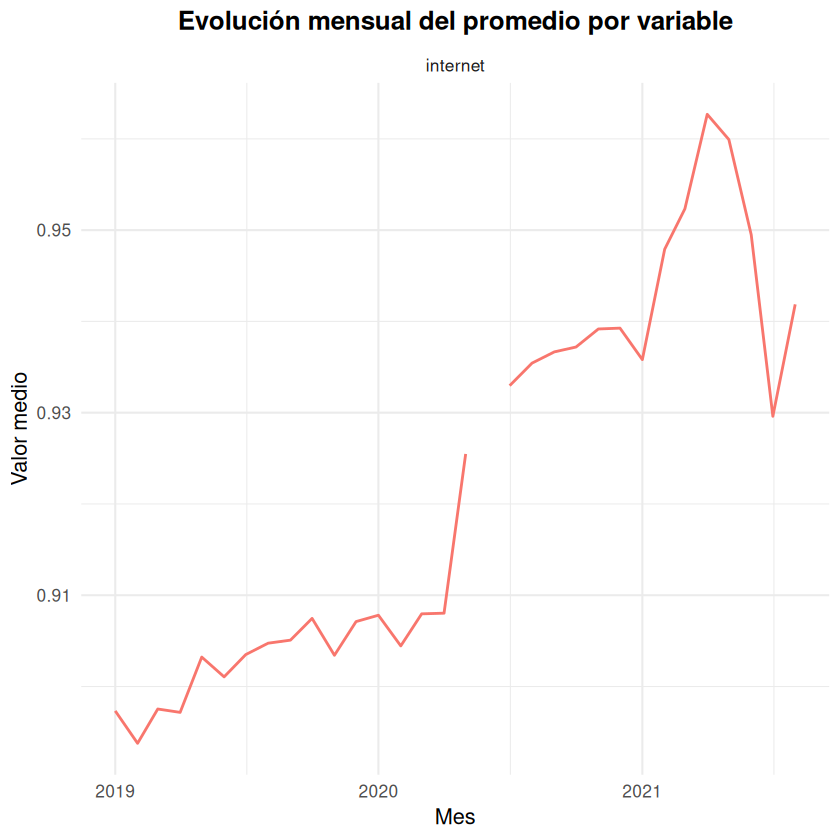

In [11]:
# VEO LAS VARIABLES QUE TIENEN CAMBIOS ABRUPTOS DE TENDENCIA
library(dplyr)
library(tidyr)
library(ggplot2)

# --- Variables de interés ---
vars_a_graficar <- c("internet")

# --- 1️⃣ Calcular el promedio mensual solo para las variables deseadas ---
mean_long <- dataset %>%
  select(foto_mes, all_of(vars_a_graficar)) %>%
  group_by(foto_mes) %>%
  summarise(across(everything(), ~mean(.x, na.rm = TRUE))) %>%
  pivot_longer(
    cols = -foto_mes,
    names_to = "variable",
    values_to = "mean_value"
  ) %>%
  mutate(fecha = as.Date(paste0(foto_mes, "01"), format = "%Y%m%d")) %>%
  ungroup()

# --- 2️⃣ Graficar todas las variables juntas (una por panel) ---
ggplot(mean_long, aes(x = fecha, y = mean_value, color = variable)) +
  geom_line(size = 0.8, show.legend = FALSE) +
  facet_wrap(~variable, scales = "free_y", ncol = 2) +
  labs(
    title = "Evolución mensual del promedio por variable",
    x = "Mes",
    y = "Valor medio"
  ) +
  theme_minimal(base_size = 13) +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))


### Data Drifting

#### Cargamos los índices

In [12]:
require(data.table)

indices_externos <- data.table(
  foto_mes = c(201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108),
  TC_BLUE = c("37,5", "39", "43,65", "46", "46", "43,8", "45,2", "63", "61,25", "69", "69,25", "78,5", "78", "78,5", "83,5", "118", "125", "126", "136", "135", "146", "169", "155", "166", "153", "146", "141", "150", "157", "168", "180,5", "182"),
  TC_OFICIAL = c("38,28", "40,14", "44,4", "45,36", "46,1", "43,7", "45,02", "62,04", "59,82", "63,23", "62,93", "62,99", "63,03", "64,26", "66,58", "69,16", "70,76", "74,07", "76,39", "78,36", "80,63", "83,89", "86,72", "89,87", "92,7", "95,12", "97,69", "98,9", "100,09", "101,17", "102,06", "103,14"),
  TCRM = c("116,5734916", "116,5625812", "119,8157416", "120,2150629", "119,4975567", "114,8101224", "109,8715912", "127,7565287", "130,6961531", "129,7797576", "126,9467229", "123,5951113", "120,8372653", "118,9226283", "114,5040182", "111,5867304", "111,7626924", "116,6307121", "117,9781145", "118,9579865", "119,6485855", "118,1736932", "119,6199112", "123,235859", "122,8366223", "122,3839332", "119,0439564", "116,7635839", "117,2617246", "116,9865438", "113,7702507", "111,9430182"),
  UVA = c("32,03", "32,86", "33,97", "35,42", "36,89", "38,03", "39,2", "40,16", "41,26", "43,43", "45,42", "47,16", "49,05", "50,49", "51,62", "52,95", "54,24", "55,06", "56,09", "57,17", "58,52", "60,16", "61,94", "64,32", "66,54", "69,04", "71,92", "74,87", "78,07", "81,13", "83,82", "86,42"),
  IPC = c("189,6101", "196,7501", "205,9571", "213,0517", "219,5691", "225,537", "230,494", "239,6077", "253,7102", "262,0661", "273,2158", "283,4442", "289,8299", "295,666", "305,5515", "310,1243", "314,9087", "321,9738", "328,2014", "337,0632", "346,6207", "359,657", "371,0211", "385,8826", "401,5071", "415,8595", "435,8657", "453,6503", "468,725", "483,6049", "498,0987", "510,3942"),
  IPIM = c("279", "288,4", "300,2", "314", "329,5", "334,9", "335,2", "372,8", "388,3", "402,3", "424", "439,7", "446,3", "451,3", "455,6", "449,7", "451,3", "467,8", "484,4", "504,2", "522,9", "547,3", "570,1", "595,2", "628,3", "666,5", "692,4", "725,5", "748,8", "772,3", "789,5", "809,4"),
  ripte_indice = c("4042", "4198,76", "4444,6", "4533,03", "4676,25", "4753,19", "4948,27", "5039,93", "5199,08", "5467,59", "5554,15", "5666,48", "6066,07", "6445,13", "6500,72", "6510,18", "6521,87", "6670,93", "6908,52", "6945,86", "7076,47", "7401,81", "7495,03", "7643,41", "7784,1", "8263,33", "8665,19", "9201,59", "9311,61", "9660,13", "10089,96", "10326,11"),
  tasa_i = c("3,71", "3,09", "3,81", "4,45", "4,42", "3,96", "4,14", "4,84", "4,91", "4,06", "3,68", "3,29", "2,83", "2,65", "2,30", "1,54", "2,21", "2,47", "2,43", "2,47", "2,47", "2,65", "2,81", "2,85", "2,85", "2,80", "2,84", "2,84", "2,84", "2,84", "2,84", "2,85"),
  tasa_r = c("0,79", "-0,68", "-0,85", "1,01", "1,28", "1,23", "1,89", "0,81", "-0,94", "0,73", "-0,59", "-0,40", "0,52", "0,64", "-0,97", "0,04", "0,70", "0,27", "0,52", "-0,23", "-0,32", "-1,11", "-0,38", "-1,10", "-1,11", "-0,77", "-1,87", "-1,21", "-0,44", "-0,35", "-0,15", "0,34")
)

# Trabajamos el formato
indices_externos[, foto_mes := as.integer(foto_mes)]

# Reemplazar la coma por el punto en todas las columnas excepto 'foto_mes'
columnas_numericas <- names(indices_externos)[-1]

indices_externos[, (columnas_numericas) := lapply(.SD, function(x) as.numeric(gsub(",", ".", x))), 
                 .SDcols = columnas_numericas]

# convertir a tasa
cols_tasas <- c("tasa_i", "tasa_r")
indices_externos[, (cols_tasas) := lapply(.SD, function(x) x / 100), .SDcols = cols_tasas]

# Verificar la estructura de la tabla
str(indices_externos)

Classes ‘data.table’ and 'data.frame':	32 obs. of  10 variables:
 $ foto_mes    : int  201901 201902 201903 201904 201905 201906 201907 201908 201909 201910 ...
 $ TC_BLUE     : num  37.5 39 43.6 46 46 ...
 $ TC_OFICIAL  : num  38.3 40.1 44.4 45.4 46.1 ...
 $ TCRM        : num  117 117 120 120 119 ...
 $ UVA         : num  32 32.9 34 35.4 36.9 ...
 $ IPC         : num  190 197 206 213 220 ...
 $ IPIM        : num  279 288 300 314 330 ...
 $ ripte_indice: num  4042 4199 4445 4533 4676 ...
 $ tasa_i      : num  0.0371 0.0309 0.0381 0.0445 0.0442 0.0396 0.0414 0.0484 0.0491 0.0406 ...
 $ tasa_r      : num  0.0079 -0.0068 -0.0085 0.0101 0.0128 0.0123 0.0189 0.0081 -0.0094 0.0073 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [13]:
require("data.table")

#' @title Deflacta columnas monetarias SOBREESCRIBIENDO las originales
#' @description Modifica las columnas monetarias (ej: 'mrentabilidad')
#'              directamente con su valor deflactado.
#'
#' @param dt El data.table principal (ej: 'dataset') que se modificará.
#' @param dt_indices El data.table que contiene todos los índices (ej: 'indices_externos').
#' @param criterio_deflacion El nombre de la columna a usar (ej: "IPC", "TCRM", "tasa_i").
#' @param incluir_dolarizadas TRUE o FALSE. Si es TRUE, ajusta pesos Y dólares.
#'                            Si es FALSE, ajusta SÓLO pesos.
#' @param mes_base Un integer (YYYYMM). Mes base para normalizar (ej: 201901).
#'
#' @return El data.table 'dt' modificado por referencia (no es necesario reasignarlo).

deflactar_dataset <- function(dt, 
                                       dt_indices, 
                                       criterio_deflacion, 
                                       incluir_dolarizadas = FALSE, 
                                       mes_base = 201901) {

  cat(paste0("Iniciando deflación según Criterio: ", criterio_deflacion, "\n"))

  # --- 1. Definir Lógicas y Columnas ---
  
  # Grupo 1: Variables en PESOS
  columnas_pesos <- c(
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen",
    "mpasivos_margen", "mcuentas_saldo", "mcuenta_corriente", "mcaja_ahorro",
    "mcuenta_corriente_adicional", "mcaja_ahorro_adicional",
    "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios",
    "mplazo_fijo_pesos", "minversion1_pesos", "minversion2",
    "mpayroll", "mpayroll2", "mcuenta_debitos_automaticos",
    "mtarjeta_visa_consumo", "mtarjeta_master_consumo",
    "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos",
    "mpagodeservicios", "mpagomiscuentas", "mtransferencias_recibidas",
    "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados",
    "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados",
    "matm", "matm_other", "mautoservicio",
    "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell",
    "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", "mtarjeta_master_descuentos",
    "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos",
    "Master_mconsumospesos", "Master_mlimitecompra", "Master_madelantopesos",
    "Master_mpagado", "Master_mpagospesos", "Master_mconsumototal", "Master_mpagominimo",
    "Visa_mfinanciacion_limite", "Visa_msaldototal", "Visa_msaldopesos",
    "Visa_mconsumospesos", "Visa_mlimitecompra", "Visa_madelantopesos",
    "Visa_mpagado", "Visa_mpagospesos", "Visa_mconsumototal", "Visa_mpagominimo"
  )
  
  # Grupo 2: Variables DOLARIZADAS
  columnas_dolares <- c(
    "mcaja_ahorro_dolares", "mplazo_fijo_dolares", "minversion1_dolares",
    "Master_msaldodolares", "Master_mconsumosdolares", "Master_madelantodolares",
    "Master_mpagosdolares",
    "Visa_msaldodolares", "Visa_mconsumosdolares", "Visa_madelantodolares",
    "Visa_mpagosdolares"
  )

  # Grupos de lógicas (actualizados a tu tabla final)
  grupo_indices <- c("IPC", "IPIM", "UVA", "ripte_indice") # Se fueron CER e indice_salarios
  grupo_tc <- c("TC_BLUE", "TC_OFICIAL", "TCRM") # Se fue TC_MAYORISTA, TC_MINORISTA
  grupo_tasas <- c("tasa_i", "tasa_r") # Nombres actualizados

  # --- 2. Validar Entradas ---
  if (!criterio_deflacion %in% names(dt_indices)) {
     stop(paste("La columna de criterio '", criterio_deflacion, "' NO existe en 'indices_externos'."))
  }
  
  # --- 3. Preparar el Índice Normalizado ---
  dt_indice_temporal <- dt_indices[, .(foto_mes, INDICE_TEMP = get(criterio_deflacion))]
  setorder(dt_indice_temporal, foto_mes)
  valor_base <- dt_indice_temporal[foto_mes == mes_base, INDICE_TEMP]
  if (length(valor_base) == 0 | is.na(valor_base)) {
    stop(paste("El 'mes_base'", mes_base, "no se encontró o es NA en el índice."))
  }

  if (criterio_deflacion %in% grupo_indices) {
    cat("... Aplicando Lógica de ÍNDICE (Base 1.0)\n")
    dt_indice_temporal[, indice_normalizado := INDICE_TEMP / valor_base]
  } else if (criterio_deflacion %in% grupo_tasas) {
    cat("... Aplicando Lógica de TASA DE INTERÉS\n")
    dt_indice_temporal[, factor := 1 + INDICE_TEMP]
    dt_indice_temporal[, indice_compuesto := cumprod(factor)]
    valor_base_compuesto <- dt_indice_temporal[foto_mes == mes_base, indice_compuesto]
    dt_indice_temporal[, indice_normalizado := indice_compuesto / valor_base_compuesto]
  } else if (criterio_deflacion %in% grupo_tc) {
    cat("... Aplicando Lógica de TIPO DE CAMBIO\n")
    dt_indice_temporal[, indice_normalizado := INDICE_TEMP]
  } else {
    warning(paste("Criterio '", criterio_deflacion, "' no está en un grupo predefinido. Se usará la Lógica de ÍNDICE por defecto."))
    dt_indice_temporal[, indice_normalizado := INDICE_TEMP / valor_base]
  }
  
  dt_indice_para_merge <- dt_indice_temporal[, .(foto_mes, indice_normalizado)]

  # --- 4. Unir el índice al dataset principal (Modifica 'dt' por referencia) ---
  dt[dt_indice_para_merge, on = "foto_mes", indice_normalizado := i.indice_normalizado]

  # --- 5. Seleccionar columnas a deflactar ---
  cols_a_deflactar_final <- columnas_pesos
  if (incluir_dolarizadas) {
    cols_a_deflactar_final <- c(cols_a_deflactar_final, columnas_dolares)
  }
  cols_a_deflactar_final <- intersect(cols_a_deflactar_final, names(dt))
  
  if (length(cols_a_deflactar_final) == 0) {
    cat("Advertencia: Ninguna columna a deflactar fue encontrada. No se hizo nada.\n")
    dt[, indice_normalizado := NULL] # Limpiar la columna de índice
    return(dt)
  }

  # --- 6. Aplicar la deflación (SOBRESCRITURA) ---
  #     (ej: mrentabilidad = mrentabilidad / indice_normalizado)
  dt[, (cols_a_deflactar_final) := lapply(.SD, function(x) {
              x / indice_normalizado
            }), .SDcols = cols_a_deflactar_final]

  # --- 7. Limpiar columna de índice ---
  dt[, indice_normalizado := NULL]

  cat("Deflación completada.", length(cols_a_deflactar_final), "columnas fueron SOBREESCRITAS.\n")
  
  # Limpieza de memoria
  rm(dt_indice_temporal, dt_indice_para_merge, cols_a_deflactar_final, 
     columnas_pesos, columnas_dolares, grupo_indices, grupo_tc, grupo_tasas)
  gc()
  
  return(dt) 
}

#### Aplicamos una metodología

In [14]:
# (En la celda de Data Drifting)
deflactar_dataset(
  dt = dataset, 
  dt_indices = indices_externos, 
  criterio_deflacion = "TCRM", #IPC , IPIM, UVA, ripte_indice, TC_BLUE, TC_OFICIAL, TCRM, tasa_i, tasa_r
  incluir_dolarizadas = FALSE,  # si es true afecta las columnas en dólares
  mes_base = 201901  #mes al que lleva el valor
)


Iniciando deflación según Criterio: TCRM
... Aplicando Lógica de TIPO DE CAMBIO
Deflación completada. 61 columnas fueron SOBREESCRITAS.


# Rankings

In [15]:
# require(data.table)

# #' @title Rankea columnas monetarias por mes (SOBREESCRIBIENDO)
# #' @description Normaliza las columnas monetarias en un rango de [-1, 1]
# #'              agrupando por foto_mes y tratando positivos y negativos
# #'              por separado.
# #'
# #' @param p_dataset El data.table a modificar.

# rank_normalizar_por_mes_monetarias <- function(p_dataset) {
  
#   # 1. Define el vector con los nombres BASE de las columnas monetarias
#   columnas_monetarias_base <- c(
#     "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen",
#     "mpasivos_margen", "mcuenta_corriente_adicional", "mcuenta_corriente",
#     "mcaja_ahorro", "mcaja_ahorro_adicional", "mcaja_ahorro_dolares",
#     "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo",
#     "mtarjeta_master_consumo", "mprestamos_personales", "mprestamos_prendarios",
#     "mprestamos_hipotecarios", "mplazo_fijo_dolares", "mplazo_fijo_pesos",
#     "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll",
#     "mpayroll2", "mcuenta_debitos_automaticos", "mtarjeta_visa_debitos_automaticos",
#     "mttarjeta_master_debitos_automaticos", "mpagodeservicios", "mpagomiscuentas",
#     "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos",
#     "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras",
#     "mforex_buy", "mforex_sell", "mtransferencias_recibidas", "mtransferencias_emitidas",
#     "mextraccion_autoservicio", "mcheques_depositados", "mcheques_emitidos",
#     "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm",
#     "matm_other", "Master_mfinanciacion_limite", "Master_msaldototal",
#     "Master_msaldopesos", "Master_msaldodolares", "Master_mconsumospesos",
#     "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos",
#     "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos",
#     "Master_mpagosdolares", "Master_mconsumototal", "Master_mpagominimo",
#     "Visa_mfinanciacion_limite", "Visa_msaldototal", "Visa_msaldopesos",
#     "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares",
#     "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares",
#     "Visa_mpagado", "Visa_mpagospesos", "Visa_mpagosdolares", "Visa_mconsumototal",
#     "Visa_mpagominimo"
#   )
  
#   # 2. Selecciona solo las columnas que realmente existen en el dataset
#   columnas_a_rankear <- intersect(columnas_monetarias_base, names(p_dataset))


#   cat("Columnas a rankear por mes (sobrescribiendo):", length(columnas_a_rankear), "\n")
#   if (length(columnas_a_rankear) == 0) {
#     cat("Advertencia: Ninguna de las columnas monetarias especificadas se encontró en el dataset.\n")
#     return(invisible(p_dataset))
#   }

#   for (col in columnas_a_rankear) {
    
#     p_dataset[, (col) := {
#       v <- .SD[[1]]
#       r <- numeric(length(v))

#       pos_idx <- which(v > 0)
#       neg_idx <- which(v < 0)

#       if (length(pos_idx) > 0) {
#         r[pos_idx] <- frank(v[pos_idx], ties.method = "average") / length(pos_idx)
#       }
#       if (length(neg_idx) > 0) {
#         r[neg_idx] <- -frank(-v[neg_idx], ties.method = "average") / length(neg_idx)
#       }

#       r[v == 0] <- 0

#       # Segunda normalización para asegurar el rango [-1, 1]
#       max_r_pos <- max(r[pos_idx], 0, na.rm = TRUE)
#       min_r_neg <- min(r[neg_idx], 0, na.rm = TRUE)

#       if (max_r_pos > 0) r[pos_idx] <- r[pos_idx] / max_r_pos
#       if (min_r_neg < 0) r[neg_idx] <- r[neg_idx] / abs(min_r_neg)

#       .(r)
#     }, by = foto_mes, .SDcols = col]
#   }



#   cat("Rankeo completado. Las columnas fueron sobrescritas.\n")
#   gc()
#   invisible(p_dataset)
# }

In [16]:
# # aplico la función
# rank_normalizar_por_mes_monetarias(dataset)



### Feature Engineering Intra-Mes

Crear variables nuevas a partir de las existentes dentro del mismo registro, **sin** ir a buscar información histórica.
<br> El siguiente código es un mínimo ejemplo, agregar nuevos features a gusto

In [17]:
# el mes 1,2, ..12 , podria servir para detectar estacionalidad
dataset[, kmes := foto_mes %% 100]

# creo un ctr_quarter que tenga en cuenta cuando
# los clientes hace 3 menos meses que estan
# ya que seria injusto considerar las transacciones medidas en menor tiempo
dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

# variable extraida de una tesis de maestria de Irlanda, se perdió el link
dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]

Sys.time()

[1] "2025-11-16 13:56:47 UTC"

### Feature Engineering Historico

In [18]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [19]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python

cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [20]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = FALSE, ratiomax = FALSE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

In [21]:
# Feature Engineering Historico
# Creacion de LAGs
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# agrego los delta lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
}

Sys.time()

[1] "2025-11-16 13:58:51 UTC"

In [22]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- TRUE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- TRUE
PARAM$FE_hist$Tendencias$minimo <- FALSE
PARAM$FE_hist$Tendencias$maximo <- FALSE
PARAM$FE_hist$Tendencias$promedio <- FALSE
PARAM$FE_hist$Tendencias$ratioavg <- FALSE
PARAM$FE_hist$Tendencias$ratiomax <- FALSE

In [23]:
# aqui se agregan las tendencias de los ultimos 6 meses

cols_lagueables <- intersect(cols_lagueables, colnames(dataset))
setorder(dataset, numero_de_cliente, foto_mes)

if( PARAM$FE_hist$Tendencias$run) {
    TendenciaYmuchomas(dataset,
    cols = cols_lagueables,
    ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
    tendencia = PARAM$FE_hist$Tendencias$tendencia,
    minimo = PARAM$FE_hist$Tendencias$minimo,
    maximo = PARAM$FE_hist$Tendencias$maximo,
    promedio = PARAM$FE_hist$Tendencias$promedio,
    ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
    ratiomax = PARAM$FE_hist$Tendencias$ratiomax
  )
}

ncol(dataset)
Sys.time()

[1] 921

[1] "2025-11-16 14:00:11 UTC"

## Modelado

No hay modelado, no se hace optimizacion de hiperparametros.

## Produccion

Las decisiones que se toman para la construccion del modelo final son:
* Los positvos son  POS={"BAJA+1", "BAJA+2"}, esta es una meticulosa decisión.
* Se entrena en los treinta meses del intervalo [201901, 202104]
* Se realiza undersampling al 5%
* Se utilizan los hiperparámetros optimos encontrados en la Bayesian Optimization
   * Se escala min_data_in_leaf

### Final Training Strategy

In [24]:
PARAM$train_final$future <- c(202108)

PARAM$train_final$training <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105, 202106
)

PARAM$train_final$undersampling <- 0.05  

In [25]:
# se filtran los meses donde se entrena el modelo final
dataset_train_final <- dataset[foto_mes %in% PARAM$train_final$training]

In [26]:
# canaritos
PARAM$train_final$lgbm$qcanaritos <- plocal$qcanaritos

cols0 <- copy(colnames(dataset_train_final))
filas <- nrow(dataset_train_final)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dataset_train_final[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dataset_train_final), cols0 ) )
  setcolorder( dataset_train_final, c( cols_canaritos, cols0 ) )
}

Sys.time()

[1] "2025-11-16 14:00:19 UTC"

#### Registros cambio las proporciones de POS/NEG

In [27]:
# Undersampling, van todos los "BAJA+1" y "BAJA+2" y solo algunos "CONTINIA"

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train_final[, azar := runif(nrow(dataset_train_final))]
dataset_train_final[, training := 0L]

dataset_train_final[
  (azar <= PARAM$train_final$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

dataset_train_final[, azar:= NULL] # elimino la columna azar

### Target Engineering

In [28]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train_final[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Models

Aqui SIEMPRE voy a hacer un semillerio, independientemente de si en la Bayesian Optimization calculé un semillerio en cada iteración.
<br> Entreno un LightGBM para cada semilla,  y guardo el modelo dentro de la carpeta  **modelitos**
<br> Intencionalmente en una primera etapá se generan los modelos y graban, y en una segunda etapa se leen eso modelos y se aplican a los datos del futuro

APO controla cuantas veces se repite el modelo, que se usa para promediar ganancias y reportar en la Pseudo Competencia algo razonable
<br> El modelo puede ser un LightGBM simple (ksemillerio==1)  o un Ensemble Semillerio( ksemillerio > 1 )
<br> Lamentablmente APO necesita utilizar muchas semillas, y eso demanda TIEMPO de corrida

In [29]:

PARAM$train_final$lgbm$param_completo <-  list(
  boosting= "gbdt",
  objective= "binary",
  metric= "custom",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE,
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_bin= 31L,
  min_data_in_leaf= plocal$min_data_in_leaf,  #este ya es el valor default de LightGBM

  num_iterations= 9999L, # dejo libre la cantidad de arboles, zLightGBM se detiene solo
  num_leaves= 9999L, # dejo libre la cantidad de hojas, zLightGBM sabe cuando no hacer un split
  learning_rate= plocal$learning_rate,  # se lo deja en 1.0 para que si el score esta por debajo de gradient_bound no se lo escale
    
  feature_fraction= 0.50, # un valor equilibrado, habra que probar alternativas ...
    
  canaritos= PARAM$train_final$lgbm$qcanaritos, # fundamental en zLightGBM, aqui esta el control del overfitting
  gradient_bound= plocal$gradient_bound   # default de zLightGBM
)

Sys.time()

[1] "2025-11-16 14:00:20 UTC"

In [30]:
# Semillerio Final
PARAM$train_final$APO <- plocal$APO
PARAM$train_final$ksemillerio  <- plocal$ksemillerio

PARAM$train_final$cortes <- c(8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000)

In [31]:
# detach("package:lightgbm", unload= TRUE)

In [32]:
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")

Loading required package: zlightgbm



In [33]:
if(!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes



In [34]:
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
PARAM$train_final$semillas <- sample(primos)[seq( PARAM$train_final$APO*PARAM$train_final$ksemillerio )]
PARAM$train_final$semillas

[1] 433073

In [35]:
campos_buenos <- setdiff(
  colnames(dataset_train_final),
  c( "clase_ternaria", "clase01", "training", "azar")
)

In [36]:
# dejo los datos en formato LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train_final[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train_final[training == 1L, clase01],
  free_raw_data= FALSE
)

cat("filas", nrow(dtrain_final), "columnas", ncol(dtrain_final), "\n")
Sys.time()

filas 256899 columnas 925 


[1] "2025-11-16 14:00:25 UTC"

In [37]:
# genero los modelitos
dir.create( "modelitos", showWarnings= FALSE)

param_completo <- copy( PARAM$train_final$lgbm$param_completo)

for( sem in PARAM$train_final$semillas ) {

  arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
  if( !file.exists( arch_modelo ) )
  {
    param_completo$seed <- sem

    modelito <- lgb.train(
      data= dtrain_final,
      param= param_completo
    )

    lgb.save( modelito, filename= arch_modelo)
    rm(modelito)
    gc()
  }
}

Sys.time()

[1] "2025-11-16 14:35:12 UTC"

### Scoring

Se hace el predict() del modelo en los datos del futuro

In [38]:
dfuture <- dataset[foto_mes %in% PARAM$train_final$future ]

cols0 <- copy(colnames(dfuture))
filas <- nrow(dfuture)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dfuture[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dfuture), cols0 ) )
  setcolorder( dfuture, c( cols_canaritos, cols0 ) )
}

In [39]:
# dataset de future, donde en este caso estoy haciendo testing

mfuture <- data.matrix(dfuture[, campos_buenos, with= FALSE])

dfuture[, ganancia := ifelse(clase_ternaria=="BAJA+2", 780000, -20000)]

In [40]:
mganancias <- matrix( nrow=PARAM$train_final$APO, ncol= length(PARAM$train_final$cortes) )

if( file.exists("prediccion.txt") )
  file.remove("prediccion.txt")

In [41]:
# aplico el modelo a los datos del future

for( vapo in seq(PARAM$train_final$APO) ) {
  # inicializacion en CERO
  vpred_acum <- rep(0.0, nrow(dfuture))
  qacumulados <- 0

  desde <- 1 + (vapo-1)*PARAM$train_final$ksemillerio
  hasta <- desde + PARAM$train_final$ksemillerio - 1
  semillas <- PARAM$train_final$semillas[desde:hasta]

  for( sem in semillas ) {

    arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
    if( file.exists( arch_modelo ) )
    {
      modelo_final <- lgb.load(arch_modelo) # leo del disco
      # hago el predict() y acumulo
      vpred_acum <- vpred_acum + predict(modelo_final, mfuture)
      qacumulados <- qacumulados + 1
      rm(modelo_final)
      gc()
    }
  }

  if( qacumulados > 0 ) {
    vpred_acum <- vpred_acum / qacumulados  # paso a probabildiad
    # tabla de prediccion, puede ser util para futuros ensembles
    #  ya que le modelo ganador va a ser un ensemble de LightGBMs

    tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes, ganancia)]
    tb_prediccion[, meta_modelo := vapo]
    tb_prediccion[, prob := vpred_acum ]
    setorder( tb_prediccion, -prob )
    # tb_prediccion[, gan_acum := cumsum(ganancia)]
    # tb_prediccion[, ganancia := NULL ]

    # # acumulo las ganancias
    # for( icor in seq(length(PARAM$train_final$cortes)) ){
    #   mganancias[ vapo, icor ] <- tb_prediccion[ PARAM$train_final$cortes[icor], gan_acum ]
    # }

    # grabo las probabilidades del modelo
    fwrite(tb_prediccion,
      file= "prediccion.txt",
      sep= "\t",
      append= TRUE
    )

    rm(tb_prediccion)
    gc()
  }
}

Sys.time()

[1] "2025-11-16 14:35:34 UTC"

In [42]:
# mganancias

### Clasificacion

Se tomó la decisión de enviar a los 11000 registros con mayor probabilidad de POS={"BAJA+1","BAJA+"}
<br> esto se determinó en forma artesanal analizando meses anterior
<br> esta es una muy importante decisión 

In [43]:
# # genero archivos con los  "envios" mejores
# dir.create("kaggle", showWarnings=FALSE)

# tb_prediccion <- fread("prediccion.txt")

In [44]:
# # genero archivos de fantasia, que NO son el que voy a subir a la Pseudo Competencia Kaggle
# envios <- 11000

# for( vapo in seq(PARAM$train_final$APO) ) {
#   if( tb_prediccion[meta_modelo==vapo, .N] > 0 ) {
#     tb_pred <- tb_prediccion[meta_modelo==vapo]
#     setorder( tb_pred, -prob )
#     tb_pred[, Predicted := 0L] # seteo inicial a 0
#     tb_pred[1:envios, Predicted := 1L] # marco los primeros

#     archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", vapo, "_", envios, ".csv")

#     # grabo el archivo
#     fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
#       file= archivo_kaggle,
#       sep= ","
#     )

#     rm( tb_pred )
#     gc()
#   }
# }

# Sys.time()

### Subida a Pseudo Kaggle

Aqui viene la verdadera magia de  APO = A Prueba Overfiteres
<br>Se sube un submit a la Pseudo Competencia Kaggle cuya ganancia coincide casi exactamente con la ganancia MEDIA , promediada  APO veces

In [45]:
# colmedias <- colMeans( mganancias, na.rm=TRUE )
# mcorte_mejor <- max(colmedias, na.rm=TRUE)
# icorte_mejor <- which.max( colmedias )
# corte_mejor <- PARAM$train_final$cortes[icorte_mejor]

In [46]:
# tbl <- as.data.table( as.list( colmedias ) )
# colnames(tbl) <- paste0( "e", PARAM$train_final$cortes )
# tbl[, experimento := PARAM$experimento ]

# exp_gral <- "/content/buckets/b1/exp/apo-gral"
# dir.create(exp_gral, showWarnings=FALSE)
# fwrite( tbl,
#   file= paste0( exp_gral, "/tb_experimentos.txt"),
#   sep= "\t",
#   append= TRUE
# )

In [47]:
# colnames( mganancias ) <- paste0( "e", PARAM$train_final$cortes )
# tbl_local <- as.data.table( mganancias )

# fwrite( tbl_local,
#   file= "tb_apo.txt",
#   sep= "\t"
# )

In [48]:
# icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
# vmodelo <- tb_prediccion[ icerca, meta_modelo ]
# tb_pred <- tb_prediccion[meta_modelo==vmodelo]

# mcorte_mejor
# icerca
# tb_prediccion[ icerca]

In [49]:
# icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
# icerca

In [50]:
# icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
# vmodelo <- tb_prediccion[ icerca, meta_modelo ]
# tb_pred <- tb_prediccion[meta_modelo==vmodelo]

# icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
# tb_pred[, Predicted := 0L] # seteo inicial a 0
# tb_pred[1:icerca, Predicted := 1L] # marco los primeros

# archivo_pseudo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_",  icerca, ".csv")

# # grabo el archivo
# fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
#   file= archivo_pseudo_kaggle,
#   sep= ","
# )


In [51]:
# # la subida a Kaggle
# comando <- "kaggle competitions submit"
# competencia <- "-c  test-202106"
# arch <- paste( "-f", archivo_pseudo_kaggle)
# mensaje <-  paste0( "-m 'exp=", PARAM$experimento,
#   "  ", paste(names(plocal), plocal, sep= "=", collapse= ";" ),
#   " envios=", icorte_mejor,"'")

                    
# linea <- paste( comando, competencia, arch, mensaje)
# salida <- system(linea, intern=TRUE)
# cat(salida)

In [52]:
Sys.time()

[1] "2025-11-16 14:35:35 UTC"